# Blackjack

### Random Action Player

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 30.38it/s]


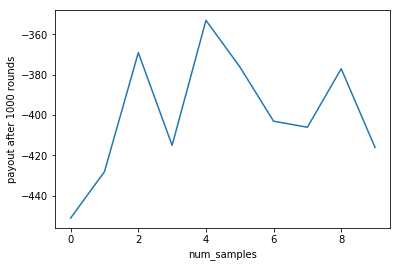

Average payout after 1000 rounds is -399.4


In [1]:
import gym
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
%matplotlib inline
env = gym.make('Blackjack-v0')
env.reset()

num_rounds = 1000 # Payout calculated over num_rounds
num_samples = 10 # num_rounds simulated over num_samples

average_payouts = []

for sample in tqdm(range(num_samples)):
    round = 1
    total_payout = 0 # to store total payout over 'num_rounds'
    
    while round <= num_rounds:
        action = env.action_space.sample()  # take random action
        #print(action) # 0 or 1
        obs, payout, is_done, _ = env.step(action)
        #print(payout)
        total_payout += payout
        if is_done:
            env.reset() # Environment deals new cards to player and dealer
            round += 1
    average_payouts.append(total_payout)

plt.plot(average_payouts)                
plt.xlabel('num_samples')
plt.ylabel('payout after 1000 rounds')
plt.show()    
print ("Average payout after {} rounds is {}".format(num_rounds, sum(average_payouts)/num_samples))

## DQN Agent

In [2]:
import random
import gym
import numpy as np
from collections import deque
from keras.models import Model
from keras.layers import Dense, Input, Lambda, Activation
from keras.optimizers import Adam
from keras import backend as K

Using TensorFlow backend.


In [3]:
class QMemoryUnit():
    def __init__(self, state, action, reward, done, next_state):
        self.state = state
        self.action = action
        self.reward = reward
        self.done = done
        self.next_state = next_state

In [4]:
memory_size = 5000
episodes = 3000
epsilon = 0.1
gamma = 0.1
minibatch_size = 512

# This returns a tensor
inputs = Input(shape=(4,))

# 2 Dense layers
full = Dense(32, activation='relu')(inputs)
full = Dense(32, activation='relu')(full)
# Split to two part
sp1,sp2 = Lambda(lambda x: [x[:,:16], x[:,16:]])(full)
# The part that calculate V(s)
value = Dense(32, activation='relu')(sp1)
value = Dense(1, activation='linear')(value)
# The part that calculate A(s,a)
advantage = Dense(32, activation='relu')(sp2)
advantage = Dense(2, activation='linear')(advantage)
# aggregate the two parts together
agg = Lambda(lambda x: x[0] + x[1] - K.mean(x[1], axis=1, keepdims=True))([value, advantage])
outputs = Dense(1, activation='linear')(agg)

model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='mean_squared_error', optimizer=Adam())

memory = deque(maxlen=memory_size)
env = gym.make('Blackjack-v0')

#valid actions
action_space = np.array([0,1])

#state + actions
action_state = np.zeros((2,4))

rewards = []
for episode in tqdm(range(episodes)):
    done = False
    state = np.array(env.reset())
    total_reward = 0
    while(not done):
        action_state[:,:3] = state
        action_state[:,3] = action_space
        
        #random choice
        if(random.random() < epsilon):
            action = np.random.choice(action_space)
        
        #action with greatest expected value
        else:
            action = np.argmax(model.predict(action_state))
            
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        
        memory.append(QMemoryUnit(state, action, reward, done, next_state))
        state = next_state
        
        minibatch = np.zeros((minibatch_size, 4))
        labels = np.zeros(minibatch_size)
        #generate minibatch and labels
        for i in range(minibatch_size):
            index = np.random.randint(0, len(memory))
            sample = memory[index]
            
            reward = sample.reward
            if(not sample.done):
                action_state[:,:3] = sample.next_state
                action_state[:,3] = action_space
                reward += gamma * np.max(model.predict(action_state))
            
            minibatch[i,:3] = sample.state
            minibatch[i,3] = sample.action
            labels[i] = reward
            
        model.fit(minibatch, labels, verbose=0)
    rewards.append(total_reward)

Instructions for updating:
Colocations handled automatically by placer.


  0%|                                                                                         | 0/3000 [00:00<?, ?it/s]

Instructions for updating:
Use tf.cast instead.


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [05:27<00:00,  9.16it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:25<00:00,  1.38it/s]


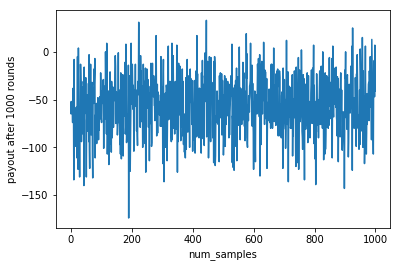

Average payout after 1000 rounds is -56.391


In [5]:
import gym
import matplotlib.pyplot as plt

env = gym.make('Blackjack-v0')
state = env.reset()
num_rounds = 1000 # Payout calculated over num_rounds
num_samples = 1000 # num_rounds simulated over num_samples

average_payouts = []

for sample in tqdm(range(num_samples)):
    round = 1
    total_payout = 0 # to store total payout over 'num_rounds'
    
    while round <= num_rounds:
        state = np.array(state)
        action_state[:,:3] = state.reshape(1, state.shape[0])
        action_state[:,3] = action_space.reshape(action_space.shape[0])
        a = model.predict(action_state)
        action = np.argmax(a.reshape((a.shape[0],a.shape[1])))
        state, payout, is_done, _ = env.step(action)
        total_payout += payout
        if is_done:
            state = env.reset() # Environment deals new cards to player and dealer
            round += 1
    average_payouts.append(total_payout)

fig = plt.figure()
plt.plot(average_payouts)                
plt.xlabel('num_samples')
plt.ylabel('payout after 1000 rounds')
plt.show()    
print ("Average payout after {} rounds is {}".format(num_rounds, sum(average_payouts)/num_samples))

In [1]:
total_reward = 0
for i in tqdm(range(num_rounds)):
    env.seed(i)
    state = env.reset()
    done = False
    while(not done):
        state = np.array(state)
        action_state[:,:3] = state.reshape(1, state.shape[0])
        a = model.predict(action_state)
        action = np.argmax(a.reshape((a.shape[0],a.shape[1])))
        state, reward, done, _ = env.step(action)
    total_reward += reward
total_reward

NameError: name 'tqdm' is not defined